<a href="https://colab.research.google.com/github/ViniciusCastillo/Aprendendo/blob/master/Analise_Base_Aprovados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/Avaliacao_Credito/main/dados/clientes_aprovados.csv')

In [3]:
print (df_aprovados.shape)
df_aprovados.head()

(1048575, 3)


,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [4]:
faixas_dict = {
    'nenhum empréstimo': 0,
    'pagamento realizado': 1,
    '1-29 dias': 2,
    '30-59 dias': 3,
    '60-89 dias': 4,
    '90-119 dias': 5,
    '120-149 dias': 6,
    '>150 dias': 7
    }
faixas_dict

{'1-29 dias': 2,
 '120-149 dias': 6,
 '30-59 dias': 3,
 '60-89 dias': 4,
 '90-119 dias': 5,
 '>150 dias': 7,
 'nenhum empréstimo': 0,
 'pagamento realizado': 1}

In [5]:
abertura = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').min()
abertura.columns = ['Abertura']
fim = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').max()
fim.columns = ['Fim']
janela = abertura.join(fim)
janela['Janela'] = janela['Fim'] - janela['Abertura']
janela.head()

,Abertura,Fim,Janela
ID_Cliente,,,
5001711,-3,0,3
5001712,-18,0,18
5001713,-21,0,21
5001714,-14,0,14
5001715,-59,0,59


In [6]:
# verifica se algum cliente fica algum mês sem dado dentro da janela
contagem = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').count()
contagem.columns = ['Contagem']
contagem = contagem.join(janela)
contagem[contagem['Contagem']-contagem['Janela'] != 1]

,Contagem,Abertura,Fim,Janela
ID_Cliente,,,,


In [7]:
aprovados = df_aprovados.join(janela, on='ID_Cliente')
aprovados['MOB'] = aprovados['Mes_referencia'] - aprovados['Abertura']
aprovados['Cod_Faixa_Atraso'] = aprovados['Faixa_atraso'].map(faixas_dict)
aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


In [8]:
qtd_clientes = janela.reset_index()[['ID_Cliente','Abertura']].groupby('Abertura').count()
qtd_clientes.columns = ['Qtd_Clientes']
qtd_clientes.head()

,Qtd_Clientes
Abertura,
-60,415
-59,406
-58,440
-57,400
-56,470


In [9]:
MOBs = pd.DataFrame(aprovados.MOB.unique(), columns=['MOB'])
MOBs.sort_values('MOB', inplace=True)
MOBs.reset_index(drop=True, inplace=True)
MOBs.head()

,MOB
0,0
1,1
2,2
3,3
4,4


In [10]:
cod_faixas = dict(aprovados.groupby(['Cod_Faixa_Atraso','Faixa_atraso']).count().index)
taxa_por_faixa = MOBs.sort_values('MOB')
qtd_clientes_total = qtd_clientes.sum()[0]
taxa_por_faixa['Qtd_Clientes'] = qtd_clientes_total
taxa_por_faixa=taxa_por_faixa.set_index('MOB')
for i in range(2,len(cod_faixas)):
  primeiro_risco_i = aprovados.query('Cod_Faixa_Atraso >= @i')[['MOB','ID_Cliente']].groupby(['ID_Cliente']).min().reset_index()
  MOBs_risco_i = primeiro_risco_i.merge(MOBs, how="cross", suffixes=('_inicial',''))
  MOBs_risco_i['Risco'] = 0
  MOBs_risco_i.loc[MOBs_risco_i['MOB'] >= MOBs_risco_i['MOB_inicial'],'Risco'] = 1
  r = MOBs_risco_i[['MOB','Risco']].groupby(['MOB']).sum()
  r.columns=['Qtd_Risco']
  taxa_por_faixa = taxa_por_faixa.join(r)
  coluna = cod_faixas[i]
  taxa_por_faixa[coluna] = taxa_por_faixa['Qtd_Risco']/taxa_por_faixa['Qtd_Clientes']
  taxa_por_faixa[coluna].fillna(0, inplace=True)
  taxa_por_faixa.drop('Qtd_Risco', axis=1, inplace=True)

taxa_por_faixa.drop(['Qtd_Clientes'], axis=1, inplace=True)
taxa_por_faixa = taxa_por_faixa*100
taxa_por_faixa.head()

,1-29 dias,30-59 dias,60-89 dias,90-119 dias,120-149 dias,>150 dias
MOB,,,,,,
0,58.314668,0.030445,0.002175,0.002175,0.002175,0.002175
1,77.296945,1.161248,0.017397,0.008698,0.008698,0.008698
2,81.139502,2.587800,0.115255,0.019572,0.017397,0.017397
3,82.539959,3.685985,0.223986,0.069588,0.030445,0.030445
4,83.375014,4.738502,0.339241,0.104382,0.069588,0.034794


In [11]:
def negrito(texto):
  return '$\\bf{'+texto.replace(' ','\ ')+'}$'

def formatar_grafico(ax, xlimite, ylimite, cor='#646369', fonte=13):
  ax.spines['bottom'].set_color(cor)
  ax.spines['left'].set_color(cor)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.tick_params(bottom=False, color=cor)
  ax.set_xlim(xlimite)
  ax.set_ylim(ylimite)
  for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(fonte)
    i.set_color(cor)
  plt.xlabel('')

def colorir_legenda(legenda, cores, cortitulo='#646369'):
  legenda.get_title().set_color(cortitulo)
  i = 0
  for texto in legenda.get_texts():
    texto.set_color(cores[i])
    i+=1

def legenda_linhas(serie, cores, distancia, ajuste=0, ajuste_ind=[0]):
  ajuste_ = ajuste
  i = 0
  for valor in serie.index:
    if len(ajuste_ind) == len(serie):
      ajuste_ = ajuste + ajuste_ind[i]
    ax.text(distancia, serie.loc[valor]+ajuste_, negrito(valor), fontsize=10, color=cores[i])
    i+=1

def plota_seta(distancia, inicial, final, cor, horientacao='v', ls=':', lw=.5):
  if horientacao == 'v':
    plt.arrow(x=distancia, y=inicial, dx=0, dy=final-inicial, color=cor, ls=ls, 
              lw=lw, head_width=.5, head_length=.3, length_includes_head=True)
  elif horientacao == 'h':
    plt.arrow(y=distancia, x=inicial, dy=0, dx=final-inicial, color=cor, ls=ls, 
              lw=lw, head_width=.5, head_length=.3, length_includes_head=True)
  else:
    print('Valor do parâmentro horientação inexistente')

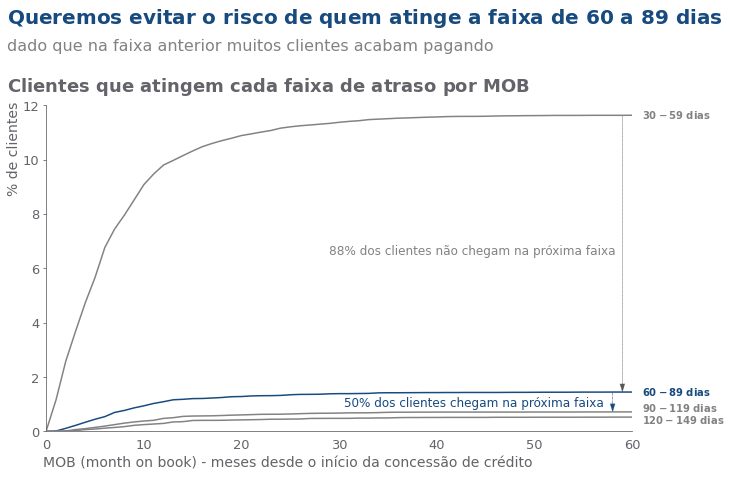

In [25]:
# define colors
grey1, grey2, grey3 = '#231F20', '#414040', '#555655'
grey4, grey5, grey6 = '#646369', '#76787B', '#828282'
grey7, grey8, grey9 = '#929497', '#A6A6A5', '#BFBEBE'
blue1, blue2, blue3, blue4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
red1, red2 = '#C3514E', '#E6BAB7'
green1, green2 = '#0C8040', '#9ABB59'
orange1 = '#F79747'

xfim = taxa_por_faixa.shape[0]-1
yfim = int(round(taxa_por_faixa.loc[xfim,'30-59 dias'],0))

relacao1 = taxa_por_faixa.loc[xfim,'60-89 dias']/taxa_por_faixa.loc[xfim,'30-59 dias']
relacao2 = taxa_por_faixa.loc[xfim,'90-119 dias']/taxa_por_faixa.loc[xfim,'60-89 dias']

cores = [grey6,blue1,grey6,grey6]

ax = taxa_por_faixa.drop(['1-29 dias','>150 dias'], axis=1).plot(figsize=(10.5, 6), color=cores, legend=False)
formatar_grafico(ax, [0, xfim], [0, yfim])
ax.text(-4, 15, negrito('Queremos evitar o risco de quem atinge a faixa de 60 a 89 dias'), fontsize=20, color=blue1)
ax.text(-4, 14, 'dado que na faixa anterior muitos clientes acabam pagando', fontsize=16, color=grey6)
ax.text(-4, 12.5, negrito('Clientes que atingem cada faixa de atraso por MOB'), fontsize=18, color=grey4)
ax.text(-4, 8.8, '% de clientes', fontsize=14, rotation='vertical', color=grey4)
ax.text(-0.3, -1.3, 'MOB (month on book) - meses desde o início da concessão de crédito', fontsize=14, color=grey4)
plota_seta(59, taxa_por_faixa.loc[59,'30-59 dias'], taxa_por_faixa.loc[59,'60-89 dias'], grey3)
ax.text(29, 6.5, f'{1-relacao1:.0%} dos clientes não chegam na próxima faixa', fontsize=12, color=cores[0])
plota_seta(58, taxa_por_faixa.loc[58,'60-89 dias'], taxa_por_faixa.loc[58,'90-119 dias'], blue1)
ax.text(30.5, 0.9, f'{relacao2:.0%} dos clientes chegam na próxima faixa', fontsize=12, color=blue1)
legenda_linhas(taxa_por_faixa.drop(['1-29 dias','>150 dias'], axis=1).loc[60], cores, 61, ajuste_ind=[-.13,-.13,0,-.25])

In [13]:
ref_risco = '60-89 dias'
aprovados['ref_risco'] = faixas_dict[ref_risco]
aprovados['Risco'] = 0
aprovados.loc[aprovados['Cod_Faixa_Atraso'] >= aprovados['ref_risco'],'Risco'] = 1
aprovados.drop('ref_risco', axis=1, inplace=True)
aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


In [14]:
primeiro_risco = aprovados.query('Risco == 1')[['MOB','ID_Cliente']].groupby(['ID_Cliente']).min().reset_index()
MOBs_risco = primeiro_risco.merge(MOBs, how="cross", suffixes=('_inicial',''))
MOBs_risco['Risco'] = 0
MOBs_risco.loc[MOBs_risco['MOB'] >= MOBs_risco['MOB_inicial'],'Risco'] = 1
MOBs_risco = MOBs_risco.join(janela, on='ID_Cliente')
MOBs_risco.head()

,ID_Cliente,MOB_inicial,MOB,Risco,Abertura,Fim,Janela
0,5002126,5,0,0,-55,0,55
1,5002126,5,1,0,-55,0,55
2,5002126,5,2,0,-55,0,55
3,5002126,5,3,0,-55,0,55
4,5002126,5,4,0,-55,0,55


In [15]:
vintage = aprovados[['ID_Cliente','Abertura','MOB']].groupby(['Abertura','MOB']).count().reset_index()
vintage = vintage.join(qtd_clientes, on='Abertura')
vintage.drop(['ID_Cliente'], axis=1, inplace=True)
risco = MOBs_risco[['Abertura','MOB','Risco']].groupby(['Abertura','MOB']).sum()
risco.columns=['Qtd_Risco']
vintage = vintage.join(risco, on=['Abertura','MOB'])
vintage['Taxa_Risco'] = vintage['Qtd_Risco']/vintage['Qtd_Clientes']
vintage['Taxa_Risco'].fillna(0, inplace=True)
vintage.Taxa_Risco.max()

0.047325102880658436

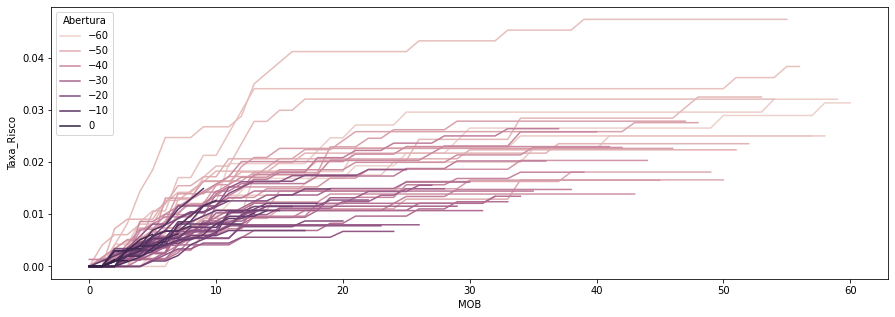

In [16]:
plt.figure(figsize=(15,5))
sns.lineplot(data=vintage, x='MOB', y='Taxa_Risco', hue='Abertura');

In [17]:
cliente_nasceu_risco = list(primeiro_risco.query('MOB == 0')['ID_Cliente'])
cliente_nasceu_risco

[5024071]

In [18]:
aprovados.query('ID_Cliente == @cliente_nasceu_risco').tail()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
269193,5024071,-34,pagamento realizado,-38,0,38,4,1,0
269194,5024071,-35,pagamento realizado,-38,0,38,3,1,0
269195,5024071,-36,1-29 dias,-38,0,38,2,2,0
269196,5024071,-37,1-29 dias,-38,0,38,1,2,0
269197,5024071,-38,>150 dias,-38,0,38,0,7,1


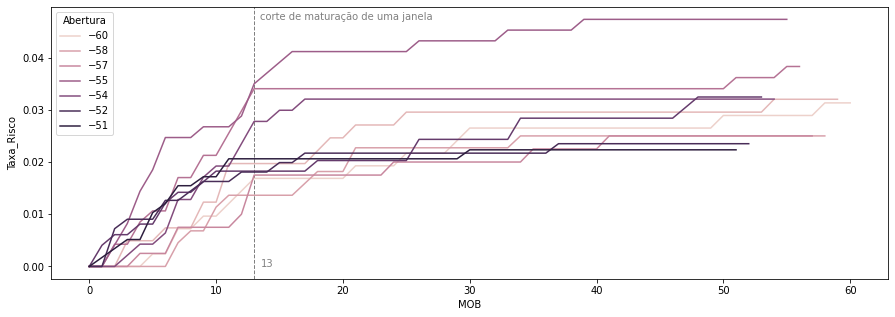

In [19]:
corte = 13
plt.figure(figsize=(15,5))
plt.text(x=corte+.5, y=vintage.Taxa_Risco.max(), s='corte de maturação de uma janela', color='grey')
plt.text(x=corte+.5, y=0, s=str(corte), color='grey')
plt.axvline(x=corte, color='grey', ls='--', lw='1')
sns.lineplot(data=vintage.loc[vintage['Abertura'] < -50], x='MOB', y='Taxa_Risco', hue='Abertura');

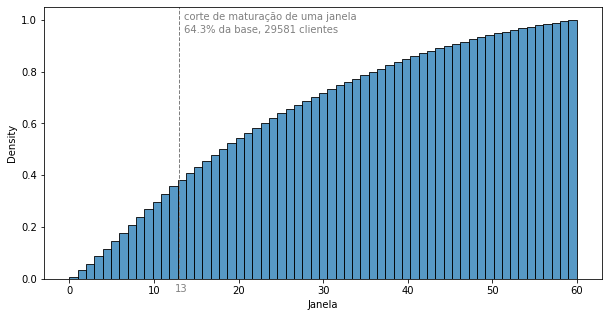

In [20]:
plt.figure(figsize=(10,5))
plt.text(x=corte+.5, y=1, s='corte de maturação de uma janela', color='grey')
plt.text(x=corte-.5, y=-.05, s=str(corte), color='grey')
corte_valor, _ = janela.loc[janela['Janela'] >= corte].shape
texto = str(round((corte_valor/qtd_clientes_total)*100,1))+"% da base, "+str(corte_valor)+" clientes"
plt.text(x=corte+.5, y=0.95, s=texto, color='grey')
plt.axvline(x=corte, color='grey', ls='--', lw='1')
sns.histplot(data=janela, x='Janela', cumulative=True, stat='density', bins=61);

In [21]:
saida = aprovados.loc[aprovados['Janela'] >= corte][['ID_Cliente','Risco']].groupby('ID_Cliente').max()
saida.shape

(29581, 1)

In [22]:
saida.to_csv('target.cvs')